In [102]:
import numpy as np
import random
import pandas as pd
import math

In [103]:
class Tour:
    def __init__(self, cities):
        self.N = len(cities)
        self.cities = cities
        self.ids = list(range(self.N))
        random.shuffle(self.ids)
        self.len = -1
        
    def length(self):
        if self.len < 0:
            self.len = sum([self.cities[self.ids[i-1]].distance(self.cities[self.ids[i]])
                            for i in range(self.N)])        
            
        return self.len
    
    


    def distance_matrix(self):
        
        matrix = [[0]*self.N for _ in range(self.N)]
        for i in range(self.N):
            for j in range(i + 1, self.N):
                dist = self.cities[i].distance(self.cities[j])
                matrix[i][j] = dist
                matrix[j][i] = dist
        return matrix
    
    
class Point2D:
    
    def __init__(self, x=None, y=None, width=999, height=666):
        if x is None:
            self.x = random.randint(1, width)
            self.y = random.randint(1, height)
        else:
            self.x, self.y = x, y
            
    def distance(self, other, x_scale=94.05163, y_scale=110.89431):
        dx = (self.x - other.x) * x_scale
        dy = (self.y - other.y) * y_scale    
        return math.sqrt(dx ** 2 + dy ** 2)
    
    def __str__(self):
        return "({:.2f}, {:.2f})".format(self.x, self.y)
    
    def __repr__(self):
        return str(self)




In [104]:
def parse_latlng(fname):
    data = pd.read_csv(fname)
    lat, lng = data['lat'].values, data['lng'].values
    return list([Point2D(x, y) for x, y in zip(lng, lat)])



In [105]:
filepath = './data/ir.csv'
ir = parse_latlng(filepath)

In [106]:
tour = Tour(ir[:20])

In [107]:
distances = []

In [108]:
import numpy as np
import random

# Calculate the total distance of a given route
def calculate_distance(route, distance_matrix):
    return sum(distance_matrix[route[i], route[i + 1]] for i in range(len(route) - 1)) + distance_matrix[route[-1], route[0]]


# Generate a random route by shuffling city indices
def generate_random_route(num_cities):
    route = list(range(num_cities))
    random.shuffle(route)
    return route

# Swap two cities in the route to create a new solution
def swap_cities(route):
    i, j = random.sample(range(len(route)), 2)
    route[i], route[j] = route[j], route[i]
    return route

# start algo 



def abc_algorithm(distance_matrix, num_bees=50, max_iter=500, limit=50):
    num_cities = len(distance_matrix)
    
    # Initialize population with random routes and calculate their fitness (distances)
    population = [generate_random_route(num_cities) for _ in range(num_bees)]
    fitness = [calculate_distance(route, distance_matrix) for route in population]
    best_route = population[np.argmin(fitness)]
    best_fitness = min(fitness)
    trial = [0] * num_bees  # Track number of trials without improvement for each bee
    
    for iteration in range(max_iter):
        
        # Employed
        # Employed bees phase: explore by swapping cities
        for i in range(num_bees):
            new_route = swap_cities(population[i][:])
            new_fitness = calculate_distance(new_route, distance_matrix)
            if new_fitness < fitness[i]: # If new solution is better, adopt it
                population[i] = new_route
                fitness[i] = new_fitness
                trial[i] = 0 # Reset trial if new solution is better 
            else:
                trial[i] += 1 # Increment trial counter if no improvement
        
        # Calculate probability for onlooker bees based on fitness
        fitness_sum = sum(1.0/f for f in fitness)
        probabilities = [(1.0/f) / fitness_sum for f in fitness]
        
        
        # Onlooker
        # Onlooker bees phase: choose routes to improve based on probabilities
        for i in range(num_bees):
            if random.random() < probabilities[i]:
                new_route = swap_cities(population[i][:])
                new_fitness = calculate_distance(new_route, distance_matrix)
                if new_fitness < fitness[i]:
                    population[i] = new_route
                    fitness[i] = new_fitness
                    trial[i] = 0
                else:
                    trial[i] += 1
        
        # Update the best solution found at this moment
        current_best_fitness = min(fitness)
        
        
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_route = population[np.argmin(fitness)]
            distances.append(best_fitness)


            
        #Scout
        # Scout bees phase: replace poor solutions that haven't improved for a while
        for i in range(num_bees):
            if trial[i] > limit:
                population[i] = generate_random_route(num_cities)
                fitness[i] = calculate_distance(population[i], distance_matrix)
                trial[i] = 0
    
    return best_route, best_fitness








In [109]:
distance_matrix = np.array(tour.distance_matrix())

best_route, best_distance = abc_algorithm(distance_matrix)
print("Best route:", best_route)
print("Best distance:", best_distance)

Best route: [19, 4, 12, 8, 13, 3, 7, 14, 6, 18, 2, 15, 5, 17, 9, 11, 1, 0, 16, 10]
Best distance: 5825.945074609041


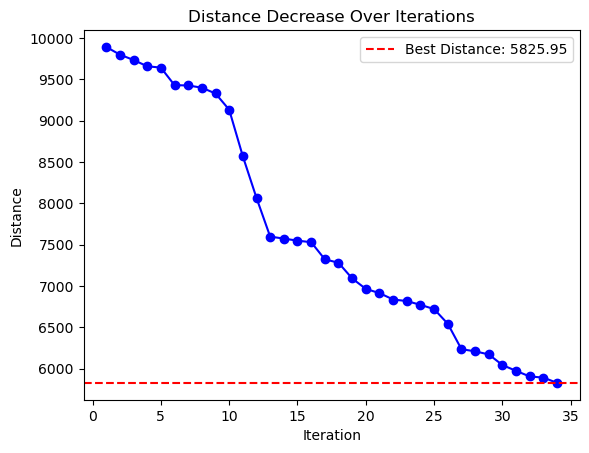

In [110]:
import matplotlib.pyplot as plt




iterations = list(range(1, len(distances) + 1))

plt.plot(iterations, distances, marker='o', linestyle='-', color='b')

plt.xlabel('Iteration')
plt.ylabel('Distance')
plt.title('Distance Decrease Over Iterations')


plt.axhline(y=min(distances), color='r', linestyle='--', label=f'Best Distance: {min(distances):.2f}')

plt.legend()

plt.show()
